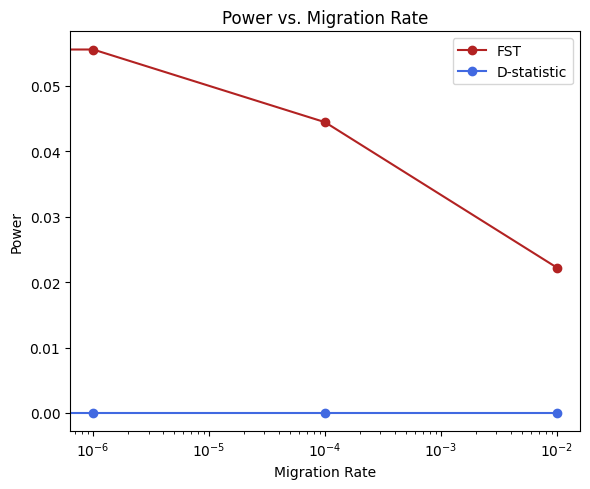

/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_43660/3527235796.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


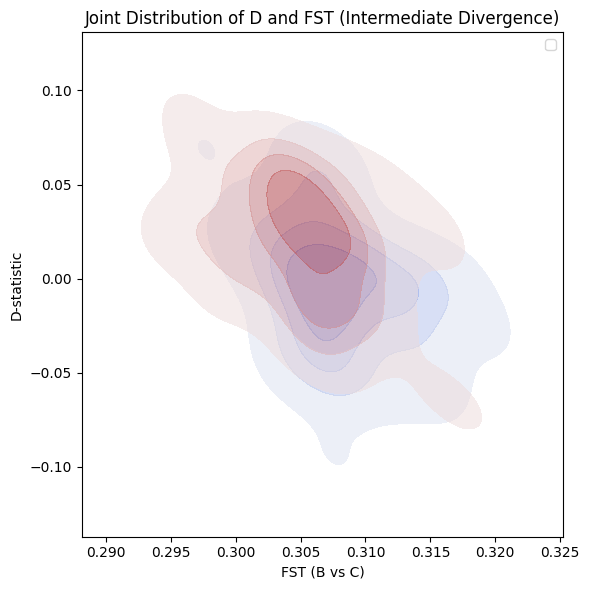

In [2]:
# 4_Power_curves.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Setup ===
Path("figures/power").mkdir(parents=True, exist_ok=True)

# === Load previous simulation data ===
df = pd.read_csv("results/mixed_updated/summary.csv")

# === Define detection thresholds ===
D_threshold = 0.2
FST_threshold = df[df["mig_rate"] == "none"]["FST_BC"].quantile(0.95)

# === Map mig_rate labels to numerical values ===
mig_rate_map = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2
}
df["mig_rate_val"] = df["mig_rate"].map(mig_rate_map)

# === Plot 1: Power vs Migration Rate ===
def compute_power(df, metric, threshold, greater_than=True):
    power_df = []
    for mig in sorted(df["mig_rate"].unique(), key=lambda x: mig_rate_map[x]):
        subset = df[df["mig_rate"] == mig]
        if greater_than:
            power = np.mean(subset[metric] > threshold)
        else:
            power = np.mean(np.abs(subset[metric]) > threshold)
        power_df.append({"mig_rate": mig, "mig_rate_val": mig_rate_map[mig], "power": power})
    return pd.DataFrame(power_df)

power_d = compute_power(df, "D", D_threshold, greater_than=False)
power_fst = compute_power(df, "FST_BC", FST_threshold, greater_than=True)

plt.figure(figsize=(6, 5))
plt.plot(power_fst["mig_rate_val"], power_fst["power"], label="FST", color="firebrick", marker='o')
plt.plot(power_d["mig_rate_val"], power_d["power"], label="D-statistic", color="royalblue", marker='o')
plt.xlabel("Migration Rate")
plt.ylabel("Power")
plt.title("Power vs. Migration Rate")
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig("figures/power/power_vs_migration.png", dpi=300)
plt.show()

# === Plot 2: Joint D vs. FST — 2D KDE ===
def plot_joint_kde(df, mig_rate_values, labels, colors, div_filter="intermediate"):
    plt.figure(figsize=(6, 6))
    for mig_label, label, color in zip(mig_rate_values, labels, colors):
        subset = df[(df["mig_rate"] == mig_label) & (df["divergence"] == div_filter)]
        sns.kdeplot(
            x=subset["FST_BC"],
            y=subset["D"],
            cmap=sns.light_palette(color, as_cmap=True),
            fill=True,
            alpha=0.5,
            label=label,
            levels=5,
            linewidths=1
        )
    plt.xlabel("FST (B vs C)")
    plt.ylabel("D-statistic")
    plt.title("Joint Distribution of D and FST (Intermediate Divergence)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("figures/power/joint_d_fst_kde.png", dpi=300)
    plt.show()

plot_joint_kde(
    df,
    mig_rate_values=["none", "high"],
    labels=["No Migration", "High Migration"],
    colors=["royalblue", "firebrick"]
)


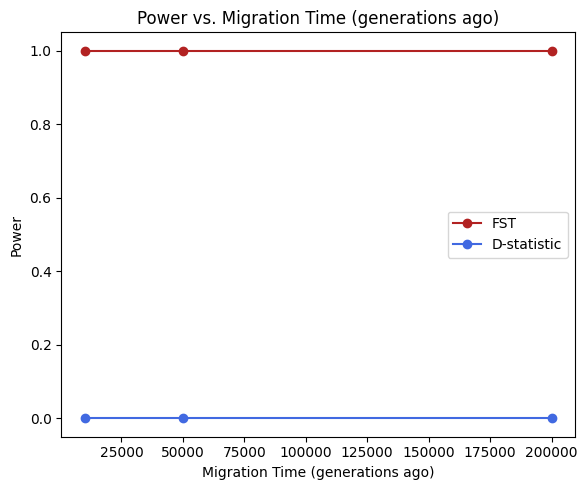

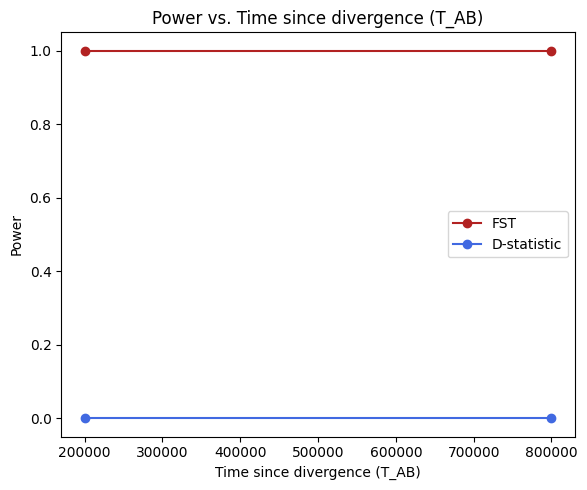

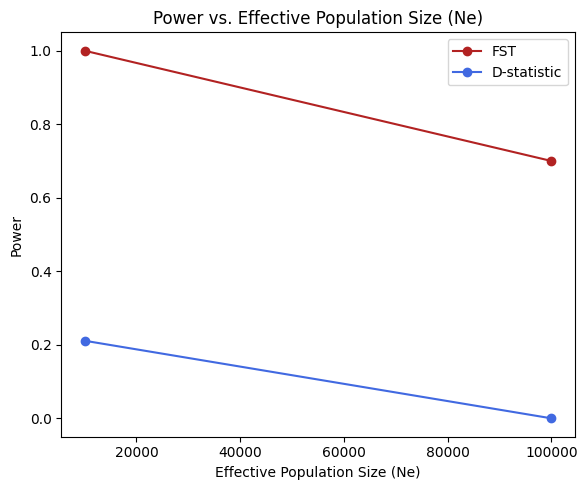

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load data ===
project_root = Path("/Users/rachaelchew/Evolutionary-Genetics-Research")
df_mixed = pd.read_csv(project_root / "notebooks/results/mixed_updated/summary.csv")
df_ils = pd.read_csv(project_root / "results/fst_distributions/ils_only.csv")

# ✅ Clip FST_BC to avoid invalid values
df_ils["FST_BC"] = df_ils["FST_BC"].clip(lower=0, upper=1)
df_mixed["FST_BC"] = df_mixed["FST_BC"].clip(lower=0, upper=1)

# === Thresholds from ILS-only ===
D_threshold = df_ils["D"].quantile(0.95)
FST_threshold = df_ils["FST_BC"].quantile(0.15)
# === Parameter maps ===
mig_time_map = {"recent": 10000, "intermediate": 50000, "ancient": 200000}
div_map = {"shallow": 200000, "intermediate": 800000}
ne_map = {"small": 10000, "large": 100000}

# === Helper: Compute power ===
def compute_power(df, metric, threshold, group_col, group_val_map=None, greater_than=True):
    power_df = []
    for val in sorted(df[group_col].unique(), key=lambda x: group_val_map.get(x, x) if group_val_map else x):
        subset = df[df[group_col] == val]
        if greater_than:
            power = (subset[metric] > threshold).mean()
        else:
            power = (subset[metric].abs() > threshold).mean()
        power_df.append({
            group_col: val,
            "value": group_val_map[val] if group_val_map else val,
            "power": power
        })
    return pd.DataFrame(power_df)

# === Helper: Plot power ===
def plot_power(df_d, df_fst, xlab, outname):
    plt.figure(figsize=(6, 5))
    plt.plot(df_fst["value"], df_fst["power"], label="FST", color="firebrick", marker='o')
    plt.plot(df_d["value"], df_d["power"], label="D-statistic", color="royalblue", marker='o')
    plt.xlabel(xlab)
    plt.ylabel("Power")
    plt.title(f"Power vs. {xlab}")
    plt.legend()
    if all(isinstance(x, (float, int)) for x in df_fst["value"]):
        plt.xscale("log" if min(df_fst["value"]) < 0.01 else "linear")
    plt.tight_layout()
    plt.savefig(f"figures/power/power_vs_{outname}.png", dpi=300)
    plt.show()

# === 1. Power vs Migration Time ===
df_time = df_mixed[
    (df_mixed["mig_rate"] == "high") &
    (df_mixed["divergence"] == "intermediate")
]
power_d_time = compute_power(df_time, "D", D_threshold, "mig_time", mig_time_map, greater_than=False)
power_fst_time = compute_power(df_time, "FST_BC", FST_threshold, "mig_time", mig_time_map, greater_than=True)
plot_power(power_d_time, power_fst_time, "Migration Time (generations ago)", "migration_time")

# === 2. Power vs Divergence ===
df_div = df_mixed[
    (df_mixed["mig_rate"] == "high") &
    (df_mixed["mig_time"] == "intermediate")
]
power_d_div = compute_power(df_div, "D", D_threshold, "divergence", div_map, greater_than=False)
power_fst_div = compute_power(df_div, "FST_BC", FST_threshold, "divergence", div_map, greater_than=True)
plot_power(power_d_div, power_fst_div, "Time since divergence (T_AB)", "divergence")

# === 3. Power vs Ne ===
power_d_ne = compute_power(df_ils, "D", D_threshold, "Ne", ne_map, greater_than=False)
power_fst_ne = compute_power(df_ils, "FST_BC", FST_threshold, "Ne", ne_map, greater_than=True)
plot_power(power_d_ne, power_fst_ne, "Effective Population Size (Ne)", "Ne")


In [31]:
print(df_div.groupby("divergence")["FST_BC"].describe())


              count      mean       std       min       25%       50%  \
divergence                                                              
intermediate   30.0  0.303718  0.004031  0.294391  0.300784  0.305237   
shallow        30.0  0.134828  0.002495  0.130048  0.133121  0.134989   

                   75%       max  
divergence                        
intermediate  0.306844  0.308647  
shallow       0.136191  0.140208  


In [17]:
print("FST threshold:", FST_threshold)
print("Max FST_BC:", df_mixed["FST_BC"].max())
print("Unique mig_time in high migration subset:", df_mixed[df_mixed["mig_rate"] == "high"]["mig_time"].unique())
print("Unique divergence in high migration subset:", df_mixed[df_mixed["mig_rate"] == "high"]["divergence"].unique())

FST threshold: 0.6578075395913087
Max FST_BC: 0.3194243482757095
Unique mig_time in high migration subset: ['recent' 'intermediate' 'ancient']
Unique divergence in high migration subset: ['shallow' 'intermediate']


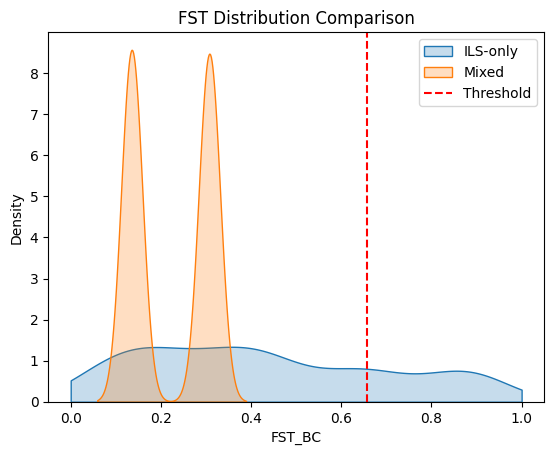

In [22]:
import seaborn as sns
sns.kdeplot(df_ils["FST_BC"], fill=True, label="ILS-only", clip=(0, 1))
sns.kdeplot(df_mixed["FST_BC"], fill=True, label="Mixed", clip=(0, 1))
plt.axvline(FST_threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("FST_BC")
plt.title("FST Distribution Comparison")
plt.legend()
plt.show()

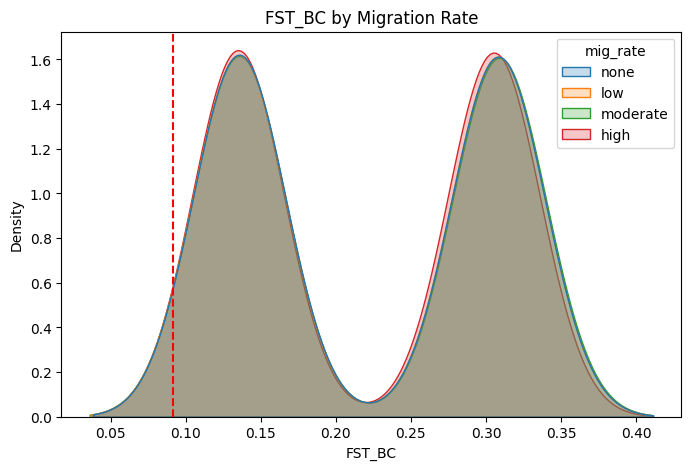

In [26]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_mixed, x="FST_BC", hue="mig_rate", fill=True)
plt.title("FST_BC by Migration Rate")
plt.axvline(FST_threshold, linestyle="--", color="red")
plt.show()